In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('src')

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizerFast, pipeline
from tqdm.auto import tqdm

from csbm.data import YelpDataset, DiscreteGaussianDataset, Prior
from csbm.utils import convert_to_numpy, fig2img, visualize_trajectory_toy
from csbm.models.toy import D3PM

import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file='checkpoints/tokenizer_yelp.json',
    padding_side='right',
    truncation_side='right',
    bos_token='<s>',
    pad_token='<pad>',
    unk_token='<unk>',
)
dataset = YelpDataset(
    sentiment='all', 
    data_dir='data', 
    # tokenizer=tokenizer,
    # max_length=45,
    split='all',
)

In [41]:
max_length = 0
pbar = tqdm(dataset, desc=f'max_length: {max_length}') # type: ignore
for text in pbar:
    lenght = len(tokenizer.encode(text))
    if lenght > max_length:
        max_length = lenght
        pbar.set_description(f'max_length: {max_length}')


max_length: 0:   0%|          | 0/448259 [00:00<?, ?it/s]

In [16]:
trainset = pd.read_json('data/amazon/amazon_small_train.jsonl', lines=True)
testset = pd.read_json('data/amazon/amazon_small_test.jsonl', lines=True)
evalset = pd.read_json('data/amazon/amazon_small_eval.jsonl', lines=True)

In [25]:
trainset.to_json('data/amazon/amazon_small_train.jsonl', lines=True, orient='records')
testset.to_json('data/amazon/amazon_small_test.jsonl', lines=True, orient='records')
evalset.to_json('data/amazon/amazon_small_eval.jsonl', lines=True, orient='records')

In [ ]:
allset = pd.concat([trainset, testset, evalset], ignore_index=True)
allset.to_json('data/yelp/amazon_small_all.jsonl', orient='records', lines=True)

In [27]:
len(allset)

2010000

In [29]:
!which python

/trinity/home/g.ksenofontov/anaconda3/bin/python


In [21]:
from csbm.data import AmazonDataset

dataset = AmazonDataset(sentiment='all', data_dir='data/', split='all')
len(dataset)

2010000

In [4]:
device = 'cpu'

In [3]:
num_categories = 50
num_timesteps = 10

dataset = DiscreteGaussianDataset(5000, dim=2, num_categories=num_categories, train=False)

In [80]:
alpha = 0.2

prior = Prior(
    alpha=alpha, 
    num_categories=num_categories, 
    num_timesteps=num_timesteps, 
    num_skip_steps=1, 
    prior_type='uniform',
).to(device)

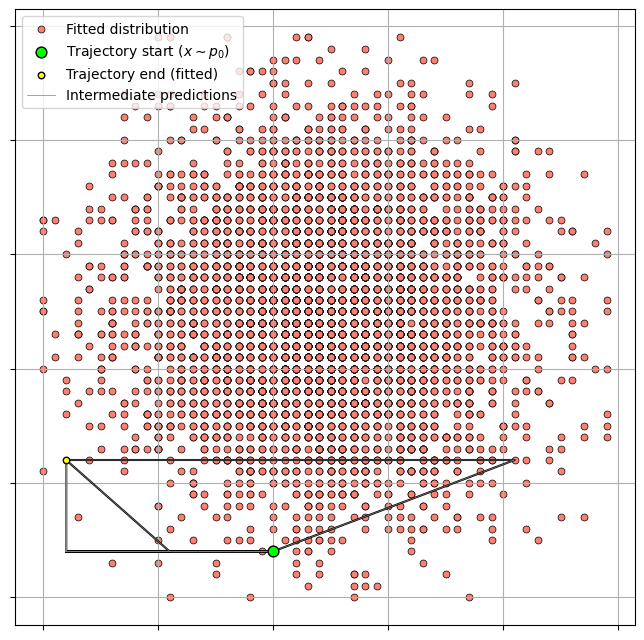

In [81]:
num_trajectories = 1
traj_start = torch.tensor([[20, 4]]).to(device)
traj_end = torch.tensor([[2, 12]]).to(device)

trajectory = [traj_start]
for t in range(num_timesteps):
    t = torch.full((num_trajectories,), t, device=device)
    trajectory.append(prior.sample_bridge(traj_start, traj_end, t))
trajectory.append(traj_end)
trajectory = torch.stack(trajectory)

trajectory = convert_to_numpy(trajectory)
visualize_trajectory_toy(dataset[:5000], trajectory, fb='forward', dpi=100)

tensor(0.8000)

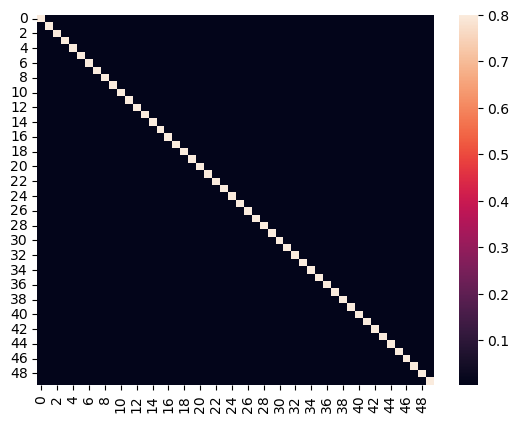

In [82]:
i = 11
sns.heatmap(prior.p_cum[i])
prior.p_cum[i].sum() / num_categories
prior.p_cum[i, 0, 0]